# Tensor Flow

In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import pickle
import matplotlib.patches as patches

%matplotlib widget

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## Model

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5,5), activation='relu', input_shape=(256,256,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

In [4]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              loss=tf.keras.losses.MeanSquaredError(),)

## Import data

In [4]:
with open('labeled_data/sources_0.obj', 'rb') as f:
    sources = pickle.load(f)

### Only original sources

In [9]:
filenames = os.listdir('labeled_data')

sources = []

for filename in filenames:
    if filename.startswith('sources'):
        print(filename)
        with open('labeled_data/' + filename, 'rb') as f:
            data = pickle.load(f)
            sources.extend(data)

sources_0.obj
sources_1.obj
sources_2.obj
sources_3.obj
sources_4.obj
sources_5.obj
sources_6.obj


In [13]:
print(len(sources))

700


### Import all sources

In [5]:
filenames = os.listdir('labeled_data')

sources = []

for filename in filenames:
    with open('labeled_data/' + filename, 'rb') as f:
        data = pickle.load(f)
        sources.extend(data)

In [6]:
print(len(sources))

4000


First time I tried 80 as the training size, that seemed to work well, but I haven't been able to replicate that early success...

In [6]:
trainingSize = 3800
testSize = len(sources)-1 - trainingSize
randomIndices = np.random.choice(len(sources), len(sources),replace=False)

In [7]:
train_images = np.empty((trainingSize, 256, 256, 3), dtype=np.float32)
train_labels = np.empty((trainingSize, 4), dtype=np.float32)
test_images = np.empty((testSize, 256, 256, 3), dtype=np.float32)
test_labels = np.empty((testSize, 4), dtype=np.float32)

For some reason number 99 doesn't work, so I had to only take up to index 98...

In [12]:
mySource = sources[randomIndices[0]]

In [15]:
(x0,x1) = (mySource.images[0].x0, mySource.images[0].x1)

In [17]:
np.array([x0,x1],dtype=np.float32)

array([  7., 256.], dtype=float32)

In [8]:
for i in range(trainingSize):
    source = sources[randomIndices[i]]
    images = np.dstack((source.images[0].data, source.images[1].data, source.images[2].data))
    (x0,x1) = (source.images[0].x0, source.images[0].x1)
    (y0,y1) = (source.images[0].y0, source.images[0].y1)
    labels = np.array([x0,x1,y0,y1])
    train_images[i] = images
    train_labels[i] = labels
for i in range(testSize):
    source = sources[randomIndices[i+trainingSize]]
    images = np.dstack((source.images[0].data, source.images[1].data, source.images[2].data))
    (x0,x1) = (source.images[0].x0, source.images[0].x1)
    (y0,y1) = (source.images[0].y0, source.images[0].y1)
    labels = np.array([x0,x1,y0,y1])
    test_images[i] = images
    test_labels[i] = labels
print("Train: ", train_images.shape)
print("Train Labels: ", train_labels.shape)
print("Test: ", test_images.shape)
print("Test Labels: ", test_labels.shape)

Train:  (3800, 256, 256, 3)
Train Labels:  (3800, 4)
Test:  (199, 256, 256, 3)
Test Labels:  (199, 4)


### Data exploration

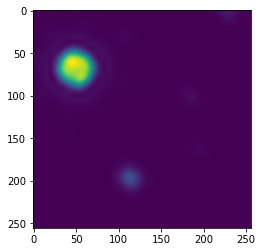

In [107]:
plt.imshow(train_images[0,:,:,2])

Need to get max values from each image set to scale values accordingly.

In [15]:
for band in range(3):
    ind = np.argpartition(train_images[:,:,:,band].flatten(), -10)[-10:]
    print('Band ', band, ': ', train_images[:,:,:,band].flatten()[ind])

Band  0 :  [0.2296933  0.2296933  0.2302746  0.2297528  0.2302746  0.2297528
 0.23036858 0.23060822 0.23036858 0.23060822]
Band  1 :  [75747.64  75747.64  75747.64  75867.57  75890.016 75867.57  75890.016
 75867.57  75890.016 75867.57 ]
Band  2 :  [175049.7  175049.7  175182.03 175182.03 175194.44 175194.44 175182.03
 175182.03 175194.44 175194.44]


Want to normalize all images.

* Band 0: divide by .15
* Band 1: divide by 70000
* Band 2: divide by 170000

After normalizing, model is much faster to train, going from loss of ~20000 -> 7000 in 50 epochs (leraning rate of 0.0002) as opposed to ~50000 -> 14000 pre-normalization. 70% used in training dataset, 30% in test.

In [9]:
def normalize_WISE(images):
    for band in [1,2]: # WISE bands
        images[:,:,:,band] = np.log10(images[:,:,:,band] - np.min(images[:,:,:,band], axis=(1,2), keepdims=True)) # Set min to 0 and log10
        images[:,:,:,band] = np.clip(images[:,:,:,band], np.median(images[:,:,:,band], axis=(1,2))[:, None, None], np.inf) # Clip to median
        images[:,:,:,band] = images[:,:,:,band] - images[:,:,:,band].min(axis=(1,2), keepdims=True) # Set min to 0
    return images

In [10]:
train_images = normalize_WISE(train_images) # Ignore warnings about divide by zero
test_images  = normalize_WISE(test_images)

C:\Users\peg20\AppData\Local\Temp\ipykernel_5156\944836610.py:3: RuntimeWarning: divide by zero encountered in log10
  images[:,:,:,band] = np.log10(images[:,:,:,band] - np.min(images[:,:,:,band], axis=(1,2), keepdims=True)) # Set min to 0 and log10


In [80]:
for band in range(3):
    ind = np.argpartition(train_images[:,:,:,band].flatten(), -10)[-10:]
    mean = np.mean(train_images[0:10,:,:,band], axis=(1,2))
    print('Band ', band, ': ', train_images[:,:,:,band].flatten()[ind])
    print('Mean: ', mean)

Band  0 :  [0.2296933  0.2296933  0.2302746  0.2297528  0.2302746  0.2297528
 0.23036858 0.23060822 0.23036858 0.23060822]
Mean:  [ 6.7661597e-07  5.1015950e-06  5.9754475e-06 -2.8621726e-06
  2.7531059e-06  9.8047758e-07  1.7375758e-05  3.7899049e-06
  1.6117872e-06  1.3040192e-04]
Band  1 :  [3.7974591 3.7989526 3.7989526 3.7989526 3.7997575 3.7997575 3.8015404
 3.7997575 3.8015404 3.8015404]
Mean:  [0.1551311  0.1174085  0.09936481 0.18975525 0.1690515  0.0923128
 0.10449693 0.33293316 0.20240192 0.1858036 ]
Band  2 :  [3.6654956 3.6664512 3.6664512 3.6664512 3.6669877 3.6669877 3.6669877
 3.667247  3.667247  3.667247 ]
Mean:  [0.09795848 0.06996097 0.05842946 0.15335797 0.10846266 0.06461721
 0.07853176 0.29981068 0.13816422 0.20749372]


In [12]:
print("Train: ", train_images.shape)
print("Train Labels: ", train_labels.shape)
print("Test: ", test_images.shape)
print("Test Labels: ", test_labels.shape)

Train:  (3800, 256, 256, 3)
Train Labels:  (3800, 4)
Test:  (199, 256, 256, 3)
Test Labels:  (199, 4)


## Model Fitting/Training

Below is the normal fitting method.

In [12]:
history = model.fit(train_images, train_labels, epochs=200)

Epoch 1/50
119/119 [==============================] - 10s 37ms/step - loss: 5314.0122
Epoch 2/50
119/119 [==============================] - 4s 35ms/step - loss: 3612.3574
Epoch 3/50
119/119 [==============================] - 4s 34ms/step - loss: 3587.1396
Epoch 4/50
119/119 [==============================] - 4s 34ms/step - loss: 3592.0911
Epoch 5/50
119/119 [==============================] - 4s 34ms/step - loss: 3566.8394
Epoch 6/50
119/119 [==============================] - 4s 34ms/step - loss: 3555.7913
Epoch 7/50
119/119 [==============================] - 4s 34ms/step - loss: 3576.5322
Epoch 8/50
119/119 [==============================] - 4s 35ms/step - loss: 3557.4917
Epoch 9/50
119/119 [==============================] - 4s 36ms/step - loss: 3524.0500
Epoch 10/50
119/119 [==============================] - 4s 35ms/step - loss: 3525.5061
Epoch 11/50
119/119 [==============================] - 4s 35ms/step - loss: 3520.0178
Epoch 12/50
119/119 [==============================] - 4s 35ms

Not entirely sure if it's fine to have the validation data in here below

In [11]:
history = model.fit(train_images, train_labels, epochs=200, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/200
119/119 [==============================] - 13s 46ms/step - loss: 6834.1650 - val_loss: 3560.2192
Epoch 2/200
119/119 [==============================] - 5s 39ms/step - loss: 3616.8179 - val_loss: 3562.8845
Epoch 3/200
119/119 [==============================] - 5s 39ms/step - loss: 3592.8411 - val_loss: 3556.7991
Epoch 4/200
119/119 [==============================] - 5s 39ms/step - loss: 3599.0579 - val_loss: 3653.0518
Epoch 5/200
119/119 [==============================] - 5s 39ms/step - loss: 3591.9355 - val_loss: 3515.6323
Epoch 6/200
119/119 [==============================] - 5s 38ms/step - loss: 3564.7227 - val_loss: 3553.8179
Epoch 7/200
119/119 [==============================] - 5s 39ms/step - loss: 3543.6753 - val_loss: 3549.2598
Epoch 8/200
119/119 [==============================] - 5s 38ms/step - loss: 3532.0029 - val_loss: 3571.5823
Epoch 9/200
119/119 [==============================] - 5s 38ms/step - loss: 3535.7827 - val_loss: 3525.7097
Epoch 10/200
119/119 [=====

In [13]:
model.predict(test_images[0:10])

1/1 [==============================] - 0s 394ms/step


array([[121.12619 , 101.92514 ,  96.74826 , 119.197914],
       [135.80423 , 118.71965 , 118.721   , 137.7473  ],
       [137.00368 , 135.11151 ,  96.821625, 162.65157 ],
       [132.64413 ,  60.276886, 130.01279 , 131.1966  ],
       [116.887375, 111.70978 , 102.37826 , 131.23247 ],
       [119.945786, 109.11848 , 124.58381 , 111.335106],
       [153.59633 ,  72.64737 , 118.612915, 157.85814 ],
       [127.2612  , 110.588905, 109.533966, 125.3527  ],
       [135.20834 , 106.915436, 106.957756, 139.41603 ],
       [290.5617  ,  -9.611412,  50.779358, 234.3221  ]], dtype=float32)

In [14]:
test_labels[0:10]

array([[141.,  61., 137.,  82.],
       [149., 102., 105., 150.],
       [145., 117., 112., 143.],
       [256.,   0.,   0., 256.],
       [146., 107.,  90., 136.],
       [155.,  82., 136.,  87.],
       [125.,  77., 177., 112.],
       [115., 152.,  98., 142.],
       [113., 143., 108., 142.],
       [256.,   0.,   0., 256.]], dtype=float32)

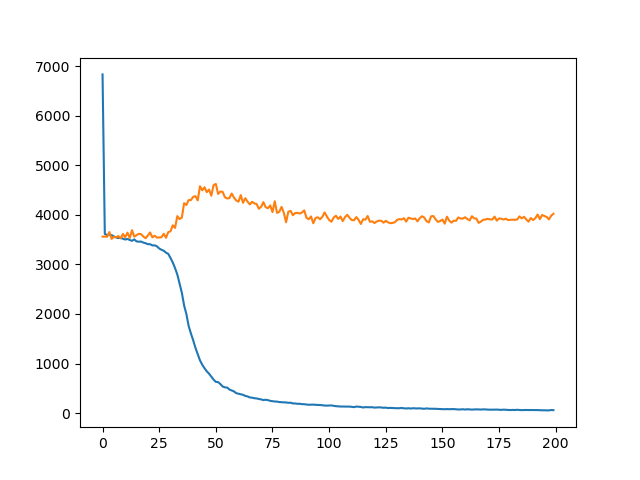

In [12]:
plt.close()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [126]:
model.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 288ms/step - loss: 34160.9492


34160.94921875

## Show predicted boxes

In [13]:
dataset = test_images[0:10]
data_labels = test_labels[0:10]

In [14]:
predict_labels = model.predict(dataset)

1/1 [==============================] - 1s 579ms/step


In [15]:
print(predict_labels)

[[173.79008  132.11752  130.6971   154.8621  ]
 [122.14818  124.04784  107.4975   132.22395 ]
 [111.08929  147.19075  140.40878  116.23255 ]
 [ 87.00858  163.76248  139.76776  101.22342 ]
 [102.99132  145.32631  131.15886  114.509636]
 [127.2162   130.83882  123.625046 135.3113  ]
 [124.38137  145.83115  126.29699  124.78586 ]
 [153.88081  106.654236 123.83201   75.409546]
 [129.75143  126.72189  122.626755 131.54164 ]
 [145.38382   72.385864  89.83798  155.19537 ]]


In [16]:
print(data_labels)

[[124. 167. 164. 118.]
 [106. 151. 105. 144.]
 [163.  91. 158.  96.]
 [ 70. 121.  94. 139.]
 [101. 151. 152. 105.]
 [ 95. 155. 107. 156.]
 [153. 113. 113. 154.]
 [ 57. 111. 131.  72.]
 [ 90. 154. 159. 104.]
 [ 51. 145. 107. 171.]]


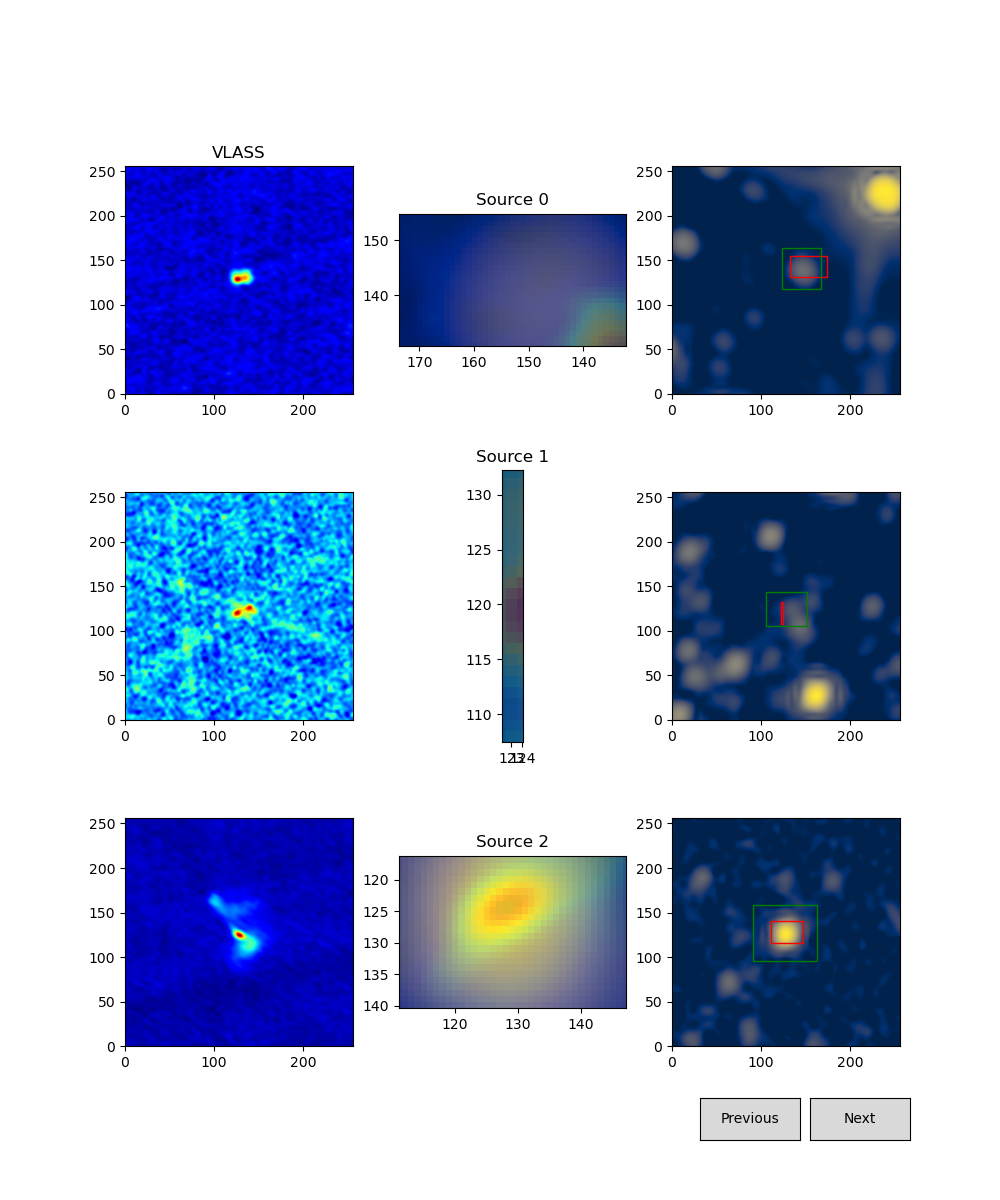

In [18]:
plt.close()

sourceLength = len(dataset)
nSources = 3

fig, ax = plt.subplots(nSources, 3, figsize=(10, 12))
ax[0][0].set_title('VLASS')
ax[0][1].set_title('VLASS + WISE')
ax[0][2].set_title('WISE')

class Index:
    ind = 0

    def next(self, event):
        self.ind += nSources
        i = self.ind % sourceLength
        self.showFigures()
        plt.draw()

    def prev(self, event):
        self.ind -= nSources
        i = self.ind % sourceLength
        self.showFigures()
        plt.draw()

    def showFigures(self):
        for i in range(nSources):
            (px0,px1,py0,py1) = predict_labels[self.ind+i]
            (x0,x1,y0,y1) = data_labels[self.ind+i]
            ax[i][0].imshow(dataset[i+self.ind,:,:,0], origin='lower', cmap='jet')
            ax[i][0].set_xlim(0, 256); ax[i][0].set_ylim(0, 256)

            ax[i][1].title.set_text('Source '+str(i+self.ind))
            ax[i][1].imshow(dataset[i+self.ind,:,:,1], origin='lower', cmap='cividis')
            ax[i][1].imshow(dataset[i+self.ind,:,:,0], origin='lower', cmap='jet', alpha=0.2)
            ax[i][1].set_xlim(px0, px1)
            ax[i][1].set_ylim(py0, py1)

            ax[i][2].cla()
            ax[i][2].imshow(dataset[i+self.ind,:,:,1], origin='lower', cmap='cividis')
            ax[i][2].set_xlim(0, 256); ax[i][2].set_ylim(0, 256)
            
            # Create a Rectangle patch
            rect = patches.Rectangle((px0, py0), px1-px0, py1-py0, linewidth=1, edgecolor='r', facecolor='none')
            # Labeled rectangle
            rect2 = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=1, edgecolor='g', facecolor='none')

            # Add the patch to the final image
            ax[i][2].add_patch(rect)
            ax[i][2].add_patch(rect2)

callback = Index()
callback.showFigures()
axprev = fig.add_axes([0.7, 0.05, 0.1, 0.035])
axnext = fig.add_axes([0.81, 0.05, 0.1, 0.035])
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

plt.show()

In [22]:
test_images.shape

(29, 256, 256, 3)